Preparación de Datos

In [3]:

import pandas as pd

exp1 = pd.read_excel("Dataset/RawData/20m/exp1.xlsx")
exp2 = pd.read_excel("Dataset/RawData/20m/exp2.xlsx")
exp3 = pd.read_excel("Dataset/RawData/25m/exp3.xlsx")
exp4 = pd.read_excel("Dataset/RawData/25m/exp4.xlsx")

# Agregar etiquetas de distancia
exp1["distancia"] = 20
exp2["distancia"] = 20
exp3["distancia"] = 25
exp4["distancia"] = 25

df = pd.concat([exp1, exp2, exp3, exp4], ignore_index=True)


print(df)

   Mote id  P1  P2  P3  P4  P5  P6  P7  P8  P9  ...  P2992  P2993  P2994  \
0    Mote1   1   1   1   1   1   1   1   1   1  ...      1      1      1   
1    Mote2   1   1   1   0   0   0   0   0   0  ...      0      0      1   
2    Mote3   1   1   1   1   1   1   1   1   1  ...      1      1      1   
3    Mote4   0   0   1   0   0   0   1   0   1  ...      0      0      0   
4    Mote5   1   1   1   1   1   1   1   1   1  ...      0      0      1   
5    Mote6   1   1   1   1   1   1   1   1   1  ...      1      1      1   
6    Mote7   1   1   1   1   1   1   1   1   1  ...      1      1      1   
7    Mote8   1   1   1   1   1   1   1   1   1  ...      1      1      1   
8    Mote9   1   1   1   1   1   1   1   1   1  ...      0      0      1   
9   Mote10   1   1   1   1   1   1   1   1   1  ...      0      0      1   
10  Mote11   1   1   1   1   1   1   1   1   1  ...      1      1      1   
11  Mote12   1   1   1   1   1   1   1   1   1  ...      1      1      1   
12  Mote13  

In [19]:
#Calculo de métricas para cada mote
#Metricas simples: tasa de éxito, cantidad de pérdidas, varianza, racha más larga de pérdidas

import numpy as np
import pandas as pd

# Filas = motes, Columnas de paquetes
packet_cols = [col for col in df.columns if col.startswith("P")]

def longest_zero_streak(row):
    """Calcula la mayor racha consecutiva de ceros"""
    max_streak = streak = 0
    for val in row:
        if val == 0:
            streak += 1
            max_streak = max(max_streak, streak)
        else:
            streak = 0
    return max_streak

# Métricas por fila
df_metrics = pd.DataFrame()
#identificador del mote
df_metrics["Mote id"] = df["Mote id"]
#distancia del experimento
df_metrics["distancia"] = df["distancia"]
#tasa de éxito
df_metrics["success_rate"] = df[packet_cols].mean(axis=1)
#cantidad de pérdidas
df_metrics["loss_count"] = (df[packet_cols] == 0).sum(axis=1)
#varianza de la recepción
df_metrics["varianza"] = df[packet_cols].var(axis=1)
#racha más larga de pérdidas
df_metrics["longest_loss_streak"] = df[packet_cols].apply(longest_zero_streak, axis=1)

#moostrar las métricas
print(df_metrics)
df_metrics.to_csv("metrics.csv", index=False)

   Mote id  distancia  success_rate  loss_count  varianza  longest_loss_streak
0    Mote1         20      0.941333         176  0.055243                   28
1    Mote2         20      0.888000         336  0.099489                   80
2    Mote3         20      1.000000           0  0.000000                    0
3    Mote4         20      0.396333        1811  0.239333                  144
4    Mote5         20      0.873667         379  0.110410                   86
5    Mote6         20      0.883667         349  0.102834                   54
6    Mote7         20      0.844667         466  0.131249                   86
7    Mote8         20      0.991000          27  0.008922                   12
8    Mote9         20      0.637667        1087  0.231125                  241
9   Mote10         20      0.380000        1860  0.235679                  317
10  Mote11         20      0.826333         521  0.143554                  127
11  Mote12         20      0.995000          15  0.0

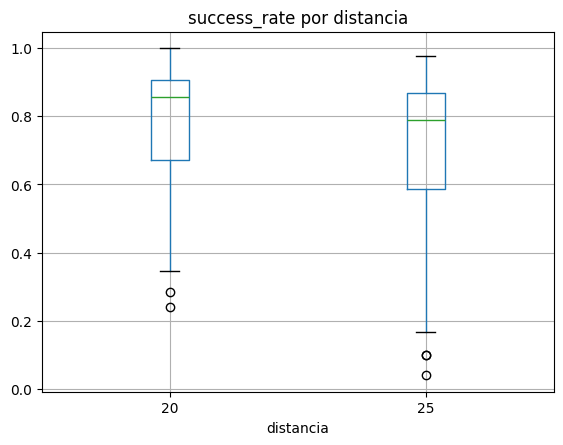

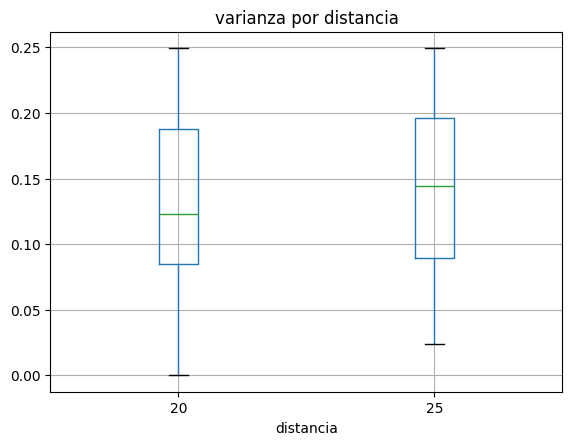

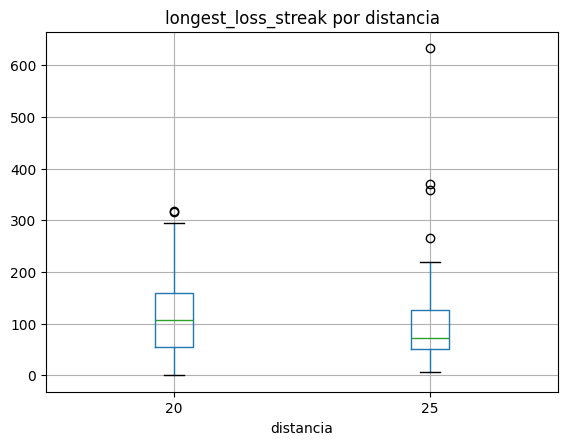

In [21]:
#Graficar las métricas
import matplotlib.pyplot as plt

for metric in ["success_rate", "varianza", "longest_loss_streak"]:
    df_metrics.boxplot(column=metric, by="distancia")
    plt.title(f"{metric} por distancia")
    plt.suptitle("")
    plt.show()

In [ ]:
#Para mejorar se deben, extraer más features
#Dividir en bloques de 500 paquetes y calcular estadísticas por bloque

import numpy as np
import pandas as pd

def extraer_features(row):
    data = row[1:].values.astype(float)  # quitamos 'Mote id'
    
    # Segmentos de 500 paquetes
    bloques = np.array_split(data, 6)
    features = {}
    for i, bloque in enumerate(bloques):
        features[f"mean_block{i+1}"] = np.mean(bloque)
        features[f"std_block{i+1}"] = np.std(bloque)
        features[f"loss_rate_block{i+1}"] = 1 - np.mean(bloque)
    
    # Longest streaks
    longest_ones, longest_zeros = 0, 0
    current_ones, current_zeros = 0, 0
    for val in data:
        if val == 1:
            current_ones += 1
            current_zeros = 0
        else:
            current_zeros += 1
            current_ones = 0
        longest_ones = max(longest_ones, current_ones)
        longest_zeros = max(longest_zeros, current_zeros)
    
    features["longest_success_streak"] = longest_ones
    features["longest_loss_streak"] = longest_zeros
    
    # Global stats
    features["success_rate"] = np.mean(data)
    features["variance"] = np.var(data)
    
    return pd.Series(features)

# Aplicar a todo el dataset concatenado
df_features = df.apply(extraer_features, axis=1)
# Guardamos la etiqueta real de cada fila
df_features["distancia"] = df["distancia"].values

print(df_features)

#Exportar a CSV
df_features.to_csv("features.csv", index=False)


    mean_block1  std_block1  loss_rate_block1  mean_block2  std_block2  \
0      0.964072    0.186111          0.035928        0.918    0.274365   
1      0.720559    0.448725          0.279441        1.000    0.000000   
2      1.000000    0.000000          0.000000        1.000    0.000000   
3      0.291417    0.454415          0.708583        0.348    0.476336   
4      0.878244    0.327004          0.121756        0.838    0.368451   
5      0.884232    0.319947          0.115768        0.884    0.320225   
6      0.862275    0.344611          0.137725        0.786    0.410127   
7      0.988024    0.108778          0.011976        1.000    0.000000   
8      0.502994    0.499991          0.497006        0.644    0.478815   
9      0.435130    0.495774          0.564870        0.548    0.497691   
10     0.782435    0.412590          0.217565        0.834    0.372081   
11     0.998004    0.044632          0.001996        1.000    0.000000   
12     0.912176    0.283039          0